#**DATA LOADING**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/UORED_scalograms"
img_size = 128
batch_size = 32

# Data generators with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_ds = datagen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset="training",
    class_mode="sparse"
)

val_ds = datagen.flow_from_directory(
    base_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset="validation",
    class_mode="sparse"
)

class_names = list(train_ds.class_indices.keys())
print("Classes:", class_names)


Found 4896 images belonging to 5 classes.
Found 1224 images belonging to 5 classes.
Classes: ['1_Healthy', '2_Inner_Race_Faults', '3_Outer_Race_Faults', '4_Ball_Faults', '5_Cage_Faults']


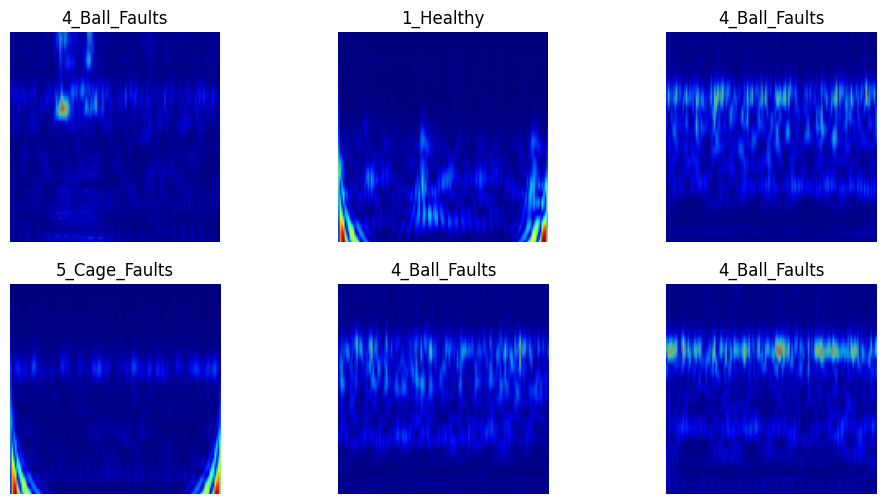

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show_tf_samples(generator, class_names, n=6):
    imgs, labels = next(generator)   # one batch
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n//2, i+1)
        plt.imshow(imgs[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    plt.show()

# Usage:
show_tf_samples(train_ds, class_names, n=6)


#**CNN**

In [3]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,317 (24.86 MB)

 Trainable params: 6,517,317 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train without validation
history = model.fit(
    train_ds,
    epochs=5   # choose number of epochs
)

# After training → evaluate on test set
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
